In [27]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.constants import physical_constants
import tinyarray

In [2]:
h_bar = physical_constants['Planck constant over 2 pi'][0]   
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]             
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  
mu_B = physical_constants['Bohr magneton'][0]  
mu_B = mu_B/eV_unit
g = -50 

In [3]:
m_ef = 0.014 * m_el
dx = 4 * 10**(-9) 
alfa = 0
t_unit_J = h_bar**(2)/(2*m_ef*dx**2) 
t = t_unit_J/eV_unit 
W = 100
L = 2000
t_so = alfa/(2*dx)

In [4]:
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])
sigma_law = np.matrix([[1, 0], [0, 2]])

In [5]:
Bx = 0
By = 0
Bz = 0.1

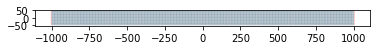

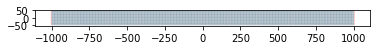

In [6]:
def make_system(B_y):  
    def onsite(site):
        By = 0
        x, y = site.pos
        if (-0.3*L <= x <= 0.3*L):
            By = B_y
        return np.array([[4*t, 0], [0, 4*t]]) + 0.5*g*mu_B*(Bx*sigma_x + By*sigma_y + Bz*sigma_z)
    
    def onsite_lead(site):
        By = 0
        return np.array([[4*t, 0], [0, 4*t]]) + 0.5*g*mu_B*(Bx*sigma_x + By*sigma_y + Bz*sigma_z)

    def ribbon(pos):
        x, y = pos
        return -L/2 <= x <= L/2 and -W/2 <= y <= W/2

    def shape_lead(pos):
        x,y = pos
        return (-W/2 < y < W/2)

    def hopping(site1, site2):
        return np.array([[-t,0],[0,-t]])



    sys = kwant.Builder()  
    lat = kwant.lattice.square(dx*10**9, norbs=2)
    sys[lat.shape(ribbon,(0,0))] = onsite
    sys[lat.neighbors()] = hopping



    leadl = kwant.Builder(kwant.TranslationalSymmetry((-dx*10**9,0)),conservation_law=sigma_law)
    leadl[lat.shape(shape_lead, (0,0))] = onsite_lead
    leadl[lat.neighbors()] = hopping

    leadr = kwant.Builder(kwant.TranslationalSymmetry((dx*10**9,0)),conservation_law=sigma_law)
    leadr[lat.shape(shape_lead, (0,0))] = onsite_lead
    leadr[lat.neighbors()] = hopping

    sys.attach_lead(leadl)
    sys.attach_lead(leadr)

    sysf = sys.finalized()

    return sysf
sysf = make_system(0)
kwant.plot(sysf)

In [20]:
def disperssion(nr_lead, k_max, nk):
    momenta = np.linspace(-k_max,k_max,nk)
    bands=kwant.physics.Bands(sysf.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta/4), energies

#funkcja liczaca wspolczynnik transmisji
def transmission_up_down(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,1), (0,0)) 
    return t

def transmission_down_down(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,1), (0,1)) 
    return t

def transmission_down_up(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,0), (0,1)) 
    return t

def transmission_up_up(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,1), (0,1)) 
    return t

#funkcja liczaca konduktacje - uzyto formuly Landauera
def conductance(Emax, ne):
    energies=np.linspace(0,Emax,ne)
    cond=[transmission(E) for E in energies]
    return energies, cond


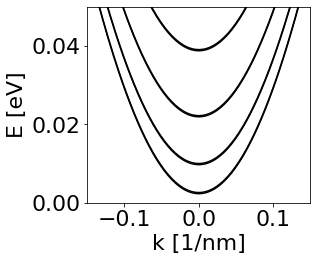

In [8]:
momenta, energies = disperssion(0, 1, 200)
plt.figure(figsize=(4,4))
plt.plot(momenta, np.asarray(energies),'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylim((0,.05))  
plt.xlim((-0.15,0.15))  
plt.xlabel("k [1/nm]",fontsize=22)
plt.ylabel("E [eV]",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
# plt.savefig("dyspersja_4jpg")
plt.show()

In [9]:
energies, cond=conductance(0.05,100)
plt.figure(figsize=(8,4))
plt.plot(energies, cond,'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel("E [eV]",fontsize=22)
plt.ylabel("G",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.savefig("konduktancja_1.png")
plt.show()

In [16]:
# Bymax = 1
# ne = 100
# E = 0.005
# By_table=np.linspace(0,Bymax,ne)
# t_down_down = []
# t_down_up = []
# t_up_down = []
# t_up_up = []
# for By in By_table:
#     sysf = make_system(By)
#     t_down_down.append(transmission_down_down(E))
#     t_up_down.append(transmission_up_down(E))
#     t_down_up.append(transmission_down_up(E))
#     t_up_up.append(transmission_up_up(E))
#     print(By)


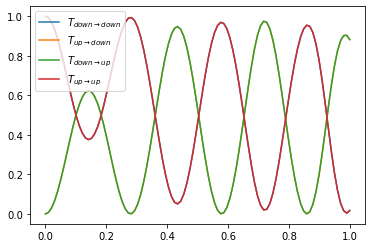

In [17]:
plt.plot(By_table, t_down_down, label = r"$T_{down \rightarrow down}$")
plt.plot(By_table, t_up_down, label = r"$T_{up \rightarrow down}$")
plt.plot(By_table, t_down_up, label = r"$T_{down \rightarrow up}$")
plt.plot(By_table, t_up_up, label = r"$T_{up \rightarrow up}$")
plt.legend()
plt.savefig("transmisja_1.png")
plt.show()

/tmp/ipykernel_17881/102834768.py:16: RuntimeWarning: The plotted data contains 0.73% of values overflowing upper limit 1.83514 
  kwant.plotter.map(sysf,density_down_map, file = "spin_down.png")


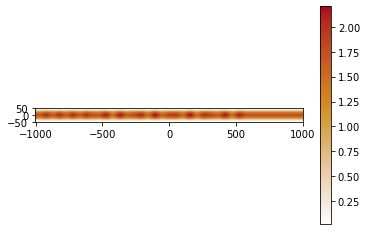

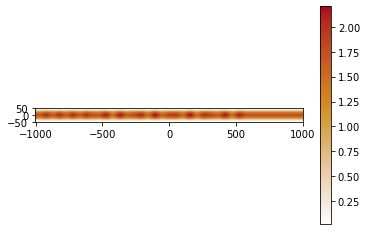

In [33]:
sysf = make_system(0.6)
wave_f=kwant.wave_function(sysf,energy = 0.005)(0)
density_up=tinyarray.array([[1,0],\
[0,0]])
density_down=tinyarray.array([[0,0],\
[0,1]])
density_both=tinyarray.array([[1,0],\
[0,1]])

density_up_op=kwant.operator.Density(sysf,density_up)
density_down_op=kwant.operator.Density(sysf,density_down)
density_both_op=kwant.operator.Density(sysf,density_both)
density_up_map=density_up_op(wave_f[0])
kwant.plotter.map(sysf,density_up_map, file = "spin_up.png")
density_down_map=density_down_op(wave_f[0])
kwant.plotter.map(sysf,density_down_map, file = "spin_down.png")
density_both_map=density_both_op(wave_f[0])
kwant.plotter.map(sysf,density_both_map)

/tmp/ipykernel_17881/177147055.py:11: RuntimeWarning: The plotted data contains 0.18% of values underflowing lower limit -1.91761 
  kwant.plotter.map(sysf, spin_z_map, file="spin_z_density.png", cmap="RdBu_r")
/tmp/ipykernel_17881/177147055.py:12: RuntimeWarning: The plotted data contains 0.38% of values overflowing upper limit 1.94012 and 0.65% of values underflowing lower limit -1.90365 
  kwant.plotter.map(sysf, spin_x_map, file="spin_x_density.png", cmap="RdBu_r")
/tmp/ipykernel_17881/177147055.py:13: RuntimeWarning: The plotted data contains 0.25% of values overflowing upper limit 0.570738 and 0.58% of values underflowing lower limit -0.606518 
  kwant.plotter.map(sysf, spin_y_map, file="spin_y_density.png", cmap="RdBu_r")


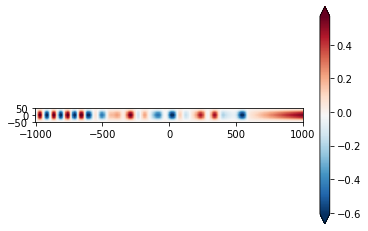

In [37]:
spin_z_op = kwant.operator.Density(sysf, sigma_z)
spin_x_op = kwant.operator.Density(sysf, sigma_x)
spin_y_op = kwant.operator.Density(sysf, sigma_y)

# Obliczamy lokalną gęstość spinu z funkcji falowej (np. kanał 0)
spin_z_map = spin_z_op(wave_f[0])
spin_x_map = spin_x_op(wave_f[0])
spin_y_map = spin_y_op(wave_f[0])

# Rysujemy gęstość spinu
kwant.plotter.map(sysf, spin_z_map, file="spin_z_density.png", cmap="RdBu_r")
kwant.plotter.map(sysf, spin_x_map, file="spin_x_density.png", cmap="RdBu_r")
kwant.plotter.map(sysf, spin_y_map, file="spin_y_density.png", cmap="RdBu_r")